# COMP9414 Assignment 2
# Reinforcement learning

@author: **Weng Xinn Chow (z5346077)**

@date: 21st July 2024

## Import libraries

In [1]:
import numpy as np
import gym
import random
import json
import os
import matplotlib.pyplot as plt

from itertools import product

## Setup environment

Possible actions:
* Move south: 0
* Move North: 1
* Move East: 2
* Move West: 3
* Pickup passenger: 4
* Dropoff passenger: 5

In [2]:
env = gym.make("Taxi-v3", render_mode="ansi").env
state = env.reset()[0]
rendered_env = env.render()
# plt.imshow(rendered_env)
print (rendered_env)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n


print(f"Number of states: {n_states}")
print(f"Number of actions: {n_actions}")

Number of states: 500
Number of actions: 6


## Train agents (Q-learning & SARSA)

For each step taken in each episode: 
1. Initialise Q-table (column: number of actions, row: number of states).
2. Choose action according to the updated Q-table.
3. Perform action: use *epsilon greedy strategy* to balance exploration and exploitation.
4. Compute rewards.
5. Update Q-table:
   * <b>Q-learning (off-policy)</b> updates Q-table using the maximum value from the next step (independent on the next action).
   * <b>SARSA (on-policy)</b> updates Q-table using the value involves the action taken in the next step.
6. Update state.
7. Update accumulated reward and steps taken per episode.

For each episode, update the **exploration rate**.
After the outer loop finished, compute the **accumulated average reward** and **average steps taken per episode**.

In [31]:
# Number of training & testing episodes
n_episodes = 10000
n_testing_episodes = 500

# Learning rate
alpha = 0.1

# Discount factor to weigh importance of future rewards
# 0: completely ignore, 1: as important as immediate reward
gamma = 0.6

# Exploration rate to decide exploration or exploitation
# Initial exploration rate
epsilon = 1.0
min_epsilon = 0.01
# Control the rate of decay of exploration
decay_rate = 0.01

In [5]:
def initialise_qtable(n_states, n_actions, max_range=0.01):
    """
    Initialise Q-table with Q-values randomly initialised 
    with a uniform distribution between 0 and the max range. 
    """
    q_table = np.random.uniform(size=(n_states, n_actions), high=max_range)
    return q_table

def select_action(q_table, state, epsilon):
    """
    Select action corresponding to the path exploration or exploitaiton
    based on the epsilon greedy policy.
    """
    # Exploration
    if random.uniform(0,1) < epsilon:
        action = env.action_space.sample()
    # Exploitation
    else: 
        action = np.argmax(q_table[state])
    return action

In [8]:
def train_agent(model, env, q_table, n_epsiodes, alpha, gamma, decay_rate, epsilon=1.0, min_epsilon=0.01):
    """
    Train agent according to the specified model, using the given parameters.
    """
    
    rewards_list = []
    steps_list = []
    
    for episode in range(n_episodes):
        # Reset the environment for each training episode
        # env.reset() returns a tuple that includes state and additional info
        state = env.reset()[0]
        
        # Accumulated rewards of the current episode
        rewards = 0
        # Number of steps taken in this episode
        steps = 0
        
        # Choose starting action using epsilon greedy policy
        action = select_action(q_table, state, epsilon)
        
        done = False
        # Loop until the process is done
        while not done: 
            # Perform action
            next_state, reward, done, _, _ = env.step(action)
            
            # Choose next action 
            next_action = select_action(q_table, next_state, epsilon)
            
            # Update q-table
            # Q-learning: use max value of next state
            if model == 1:
                next_value = np.max(q_table[next_state])
                q_table[state,action] = q_table[state,action] + alpha * (reward + (gamma * next_value) - q_table[state,action])
            # Sarsa: use value involves next action taken in next step
            else: 
                next_value = q_table[next_state,next_action]
                q_table[state,action] = q_table[state,action] + alpha * (reward + (gamma * next_value) - q_table[state,action])
            
            # Update state
            state = next_state
            
            # Update action to the next chosen action
            action = next_action
            
            # Update accumulated rewards
            rewards += reward
            
            # Count steps taken
            steps += 1
            
        # Update epsilon using exponential decay formula
        # Reduce epsilon in each episode as we need less and less exploration and more exploitation
        # As episode increases, the value of decaying function decreases
        # The formula ensure the epsilon will not fall below the min epsilon
        epsilon = max(min_epsilon, np.exp(-decay_rate * episode))
            
        # Update rewards ans steps lists
        rewards_list.append(rewards)
        steps_list.append(steps)
        
    # Compute average accumulated reward and average steps taken
    avg_rewards =np.mean(rewards_list)
    avg_steps = np.mean(steps_list)
        
    return q_table, avg_rewards, avg_steps, rewards_list, steps_list

## Hyperparameter-tuning using grid search

1. Learning rate (*alpha*)
    * Determines the rate of the agent learning the newly aquired information.
    * A higher learning rate means the agent quickly adapts to the new information, while a lower learning rate indicates that it retains its prior knowledge for a longer time. 
2. Discount factor (*gamma*)
    * Determines the importance of future rewards compared to the immediate reward.
    * A lower discount factor prioritises the immediate reward while a higher discount factor (closer to 1) takes future rewards more important.
3. Minimum exploration rate (*min_epsilon*)
    * Determines the minimum value of the exploration rate during exponential decay. 
    * The exploration rate determines the likelihood of exploration of new methods or exploitation of known actions.
    * An optimal min epsilon ensurse the agent to explore occasionally when reaching the later part of training to avoid local optima and has the ability to adapt to dynamic or partially observed environment. 
    * Note that fixed epsilon (maximum exploration rate => 1.0) is used. 
4. Decay rate (*decay_rate*)
    * Determine the rate of exponential decay of the exploration rate for each episode during training. 
    * A higher decay rate indicates a more drastic decrease of exploration rate over episodes, leading to a faster transition from exploration to exploitation.
    * A lower decay rate means a slower shifting of agent's behaviour from exploration to exploitation.

In [ ]:
# Hyperparameters to tune
alphas = [0.01, 0.1, 0.5]
gammas = [0.6, 0.8, 0.9, 0.99]
min_epsilons = [0.01, 0.1]
decay_rates = [0.001, 0.01, 0.1]

In [9]:
def save_to_file(data, filename):
    """
    Save data to a json file.
    """
    with open(filename, 'w') as file:
        json.dump(data, file)
        
def load_from_file(filename):
    """
    Load json object from file.
    """
    if os.path.exists(filename):
        with open(filename, 'r') as file:
            return json.load(file)
    else:
        return None

def tune_hyperparameters(model, env, alphas, gammas, decay_rates, min_epsilons, epsilon, filename):
    # Load tuned best params from file (if any)
    best_params = load_from_file(filename)
    if best_params:
        print(best_params)
        return best_params
        
    best_score = float("-inf")
    
    all_combs = product(alphas, gammas, min_epsilons, decay_rates)
    for alpha, gamma, min_epsilon, decay_rate in all_combs:
        print(f"Tuning alpha={alpha}, gamma={gamma}, min_epsilon={min_epsilon}, decay_rate={decay_rate}")
        
        # Initialise q-table
        q_table = initialise_qtable(n_states, n_actions)
        
        # Train with the current combination
        q_table, avg_rewards, avg_steps, rewards_list, steps_list = train_agent(model, 
                                                                                env, 
                                                                                q_table, 
                                                                                n_episodes, 
                                                                                alpha, 
                                                                                gamma, 
                                                                                decay_rate, 
                                                                                epsilon=epsilon,
                                                                                min_epsilon=min_epsilon)
        # Compute score based on average rewards and average steps per episode
        # Maximise average rewards and minimise average steps
        score = avg_rewards - avg_steps
        print(f"Average accumulated rewards: {avg_rewards}")
        print(f"Average number of steps: {avg_steps}")
        print(f"Score: {score}\n")
        
        if score > best_score:
            best_score = score
            best_params = {
                "alpha": alpha, 
                "gamma": gamma, 
                "min_epsilon": min_epsilon, 
                "decay_rate": decay_rate
            }
    
    print("===========================================================")
    print("Finished tuning")
    
    # Save best params to file
    save_to_file(best_params, filename)
    
    print("Best params")
    print(best_params)
    
    return best_params

## Test agents

For each step taken in each episode:
1. Initialise Q-table (column: number of actions, row: number of states).
2. Choose action that gives the maximum future reward.
3. Perform action and compute reward.
4. Update state.
5. Update accumulated reward and steps taken per episode.
6. The inner loop ends when the process is done (agent falls into hole or the goal is achieved), or the number steps taken reached the max steps.

After the outer loop finished, compute **average accumulated reward** and **average steps taken**.

In [120]:
def test_agent(env, q_table, n_episodes, max_steps=100, seed=None):
    # Random seed for consistent environment across run
    if seed is not None:
        np.random.seed(seed)
        env.seed(seed)
        
    rewards_list = []
    steps_list = []
    
    for episode in range(n_episodes):
        # Reset the environment for each training episode
        # env.reset() returns a tuple that includes state and additional info
        state = env.reset()[0]
        
        # Accumulated rewards of the current episode
        rewards = 0
        # Number of steps taken in this episode
        steps = 0
        
        print(f"Episode: {episode}")
        done = False
        # Loop until the process is done or when steps taken exceeds the max steps
        while not done and steps < max_steps:
            # Choose action the gives the max future reward
            action = np.argmax(q_table[state])
            
            # Perform action
            next_state, reward, done, _, _ = env.step(action)
            
            # Update state
            state = next_state
            
            # Update accumulated rewards
            rewards += reward
            
            # Count steps taken
            steps += 1
            
            # Visualise the steps taken and how reward changes from one state to another
            print(env.render())
            print(f"Step: {steps}")
            print(f"State: {state}, Action: {action}, Reward: {reward}, Total Accumulated Reward: {rewards}")
            
        # Update rewards ans steps lists
        rewards_list.append(rewards)
        steps_list.append(steps)
        
        print("=========================================================================\n")
        
    # Compute average accumulated reward and average steps taken
    avg_rewards = np.mean(rewards_list)
    avg_steps = np.mean(steps_list)
    
    return avg_rewards, avg_steps, rewards_list, steps_list

## Q-learning

### Baseline model

In [139]:
# Train baseline q-learning model
state = env.reset()[0]
model = 1
q_ql_0 = initialise_qtable(n_states, n_actions)
q_ql_0, avg_rewards_ql_0, avg_steps_ql_0, rewards_ql_0, steps_ql_0 = train_agent(model, env, q_ql_0, n_episodes, alpha, \
                                                                                 gamma, decay_rate, epsilon=epsilon, \
                                                                                 min_epsilon=min_epsilon)

In [140]:
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



In [141]:
print("Q-learning baseline model:")
print(f"Average accumulated reward: {avg_rewards_ql_0}")
print(f"Average steps taken per episode: {avg_steps_ql_0}")

Q-learning baseline model:
Average accumulated reward: -23.6331
Average steps taken per episode: 27.5043


### Hyperparameter-tuning

In [143]:
# Tune hyperparameters (fixed starting epsilon)
params_file_ql = "best_params_ql.json"
best_params_ql = tune_hyperparameters(model, env, alphas, gammas, decay_rates, min_epsilons, epsilon, params_file_ql)

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.01, decay_rate=0.001
Average accumulated rewards: -267.6772
Average number of steps: 132.5713
Score: -400.24850000000004

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.01, decay_rate=0.01
Average accumulated rewards: -130.4055
Average number of steps: 115.7997
Score: -246.2052

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.01, decay_rate=0.1
Average accumulated rewards: -109.0726
Average number of steps: 113.365
Score: -222.43759999999997

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.1, decay_rate=0.001
Average accumulated rewards: -284.705
Average number of steps: 135.3206
Score: -420.0256

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.1, decay_rate=0.01
Average accumulated rewards: -158.5301
Average number of steps: 119.4596
Score: -277.98969999999997

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.1, decay_rate=0.1
Average accumulated rewards: -135.3535
Average number of steps: 116.7607
Score: -252.11419999999998

Tuning alpha=0.01, gamma=0.8, min_e

Average accumulated rewards: -4.9442
Average number of steps: 18.017
Score: -22.961199999999998

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.01, decay_rate=0.001
Average accumulated rewards: -37.8213
Average number of steps: 25.3026
Score: -63.123900000000006

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.01, decay_rate=0.01
Average accumulated rewards: -8.0525
Average number of steps: 17.7332
Score: -25.7857

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.01, decay_rate=0.1
Average accumulated rewards: 1.6989
Average number of steps: 15.9
Score: -14.2011

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.1, decay_rate=0.001
Average accumulated rewards: -40.5947
Average number of steps: 26.1923
Score: -66.787

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.1, decay_rate=0.01
Average accumulated rewards: -13.3334
Average number of steps: 19.2845
Score: -32.6179

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.1, decay_rate=0.1
Average accumulated rewards: -4.7592
Average number of steps: 17.6979
Score: -22.457

### Training

In [144]:
# Train using tuned parameters (fixed starting epsilon)
alpha_ql = best_params_ql["alpha"]
gamma_ql = best_params_ql["gamma"]
min_epsilon_ql = best_params_ql["min_epsilon"]
decay_rate_ql = best_params_ql["decay_rate"]

state = env.reset()[0]
q_ql = initialise_qtable(n_states, n_actions)
q_ql, avg_rewards_ql, avg_steps_ql, rewards_ql, steps_ql = train_agent(model, env, q_ql, n_episodes, alpha_ql, gamma_ql, \
                                                                       decay_rate_ql, epsilon=epsilon, min_epsilon=min_epsilon_ql)

In [145]:
print("Q-learning trained model:")
print(f"Average accumulated reward: {avg_rewards_ql}")
print(f"Average steps taken per episode: {avg_steps_ql}")

Q-learning trained model:
Average accumulated reward: 1.0894
Average steps taken per episode: 16.1378


In [146]:
# Save q-table to file
qtable_file_ql = "qtable_ql.json"
save_to_file(q_ql.tolist(), qtable_file_ql)

#### Plots for accumulated rewards and number of steps taken per episode

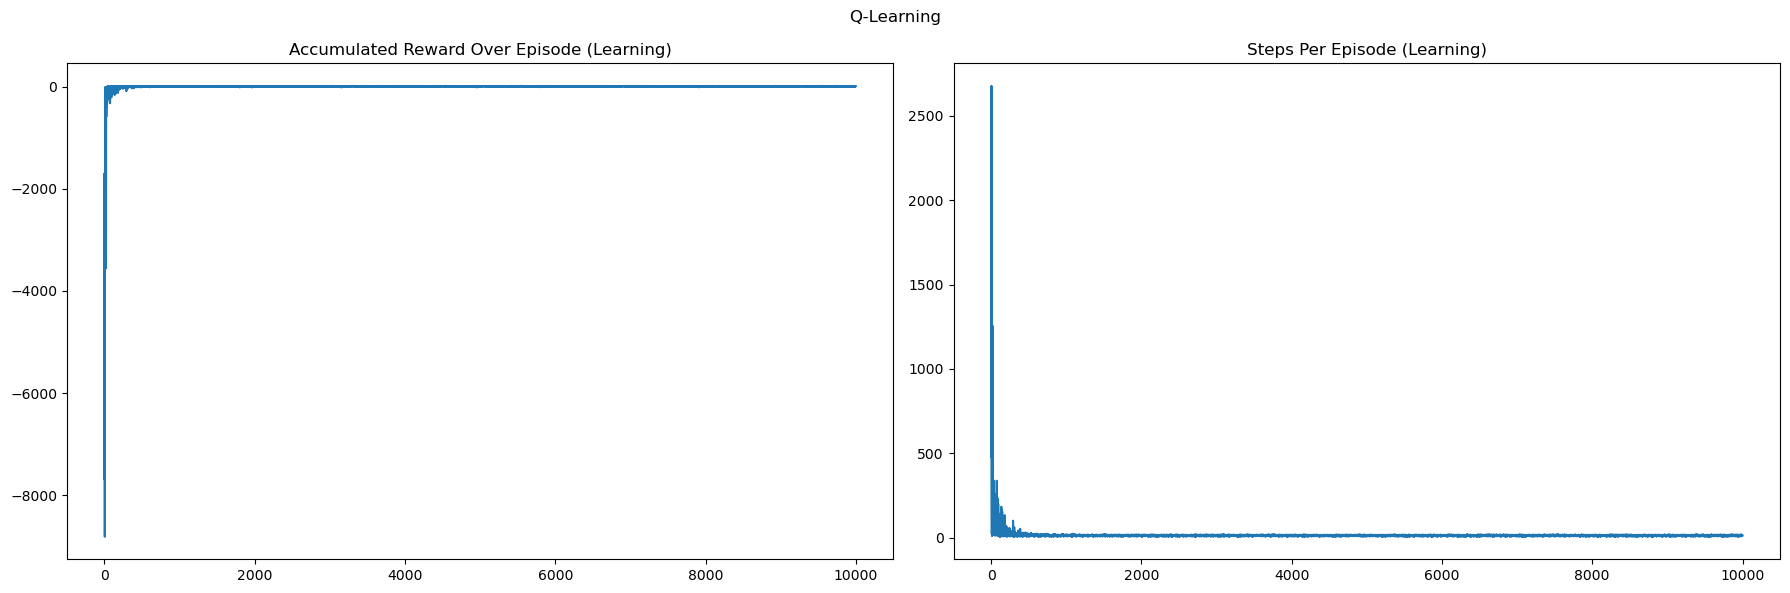

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=100)
axes = axes.flatten()

# Accumulated rewards for each episode
axes[0].plot(rewards_ql) 
axes[0].set_title("Accumulated Reward Over Episode (Learning)")

# Number of steps taken for each episode
axes[1].plot(steps_ql) 
axes[1].set_title("Steps Per Episode (Learning)")

fig.suptitle("Q-Learning")

plt.tight_layout()
plt.show()

In [148]:
# Load q-table from file
q_ql = np.array(load_from_file(qtable_file_ql))

# Test the trained q-learning agent
state = env.reset()[0]
seed = 42
avg_rewards_ql2, avg_steps_ql2, rewards_ql2, steps_ql2 = test_agent(env, q_ql, 1, seed)

Episode: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 1
State: 227, Action: 2, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 2
State: 247, Action: 2, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 3
State: 267, Action: 2, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 4
State: 167, Action: 1, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 5
State: 187, Action: 2, Reward: -1, Total Accumulated Reward: -5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 6
State: 87, Action: 1, Reward: -1, Total Accumulated Rew

### Testing

In [149]:
# Load q-table from file
q_ql = np.array(load_from_file(qtable_file_ql))

# Test the trained q-learning agent
state = env.reset()[0]
avg_rewards_ql2, avg_steps_ql2, rewards_ql2, steps_ql2 = test_agent(env, q_ql, n_testing_episodes, seed)

Episode: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 1
State: 409, Action: 0, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: 2
State: 417, Action: 4, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)

Step: 3
State: 317, Action: 1, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 4
State: 217, Action: 1, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 5
State: 237, Action: 2, Reward: -1, Total Accumulated Reward: -5
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 6
State: 257, Action: 2, Reward: -1, Total Accumulated

+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 9
State: 178, Action: 0, Reward: -1, Total Accumulated Reward: -9
+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 10
State: 158, Action: 3, Reward: -1, Total Accumulated Reward: -10
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 11
State: 258, Action: 0, Reward: -1, Total Accumulated Reward: -11
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 12
State: 238, Action: 3, Reward: -1, Total Accumulated Reward: -12
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 13
State: 218, Action: 3, Reward: -1, Total Accumulated Reward: -13
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)

Step: 14
State: 318, Action: 0, Reward: -1, Total Accumulated Rew

+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 6
State: 158, Action: 3, Reward: -1, Total Accumulated Reward: -6
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 7
State: 258, Action: 0, Reward: -1, Total Accumulated Reward: -7
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 8
State: 238, Action: 3, Reward: -1, Total Accumulated Reward: -8
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 9
State: 218, Action: 3, Reward: -1, Total Accumulated Reward: -9
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)

Step: 10
State: 318, Action: 0, Reward: -1, Total Accumulated Reward: -10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 11
State: 418, Action: 0, Reward: -1, Total Accumulated Reward: -

+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 7
State: 117, Action: 0, Reward: -1, Total Accumulated Reward: -7
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 8
State: 217, Action: 0, Reward: -1, Total Accumulated Reward: -8
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 9
State: 237, Action: 2, Reward: -1, Total Accumulated Reward: -9
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 10
State: 257, Action: 2, Reward: -1, Total Accumulated Reward: -10
+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 11
State: 157, Action: 1, Reward: -1, Total Accumulated Reward: -11
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 12
State: 177, Action: 2, Reward: -1, Total Accumulated Reward:

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: 7
State: 419, Action: 4, Reward: -1, Total Accumulated Reward: -7
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)

Step: 8
State: 319, Action: 1, Reward: -1, Total Accumulated Reward: -8
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 9
State: 219, Action: 1, Reward: -1, Total Accumulated Reward: -9
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 10
State: 239, Action: 2, Reward: -1, Total Accumulated Reward: -10
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 11
State: 259, Action: 2, Reward: -1, Total Accumulated Reward: -11
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 12
State: 279, Action: 2, Reward: -1, Total Accumulated Reward

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 8
State: 217, Action: 0, Reward: -1, Total Accumulated Reward: -8
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 9
State: 237, Action: 2, Reward: -1, Total Accumulated Reward: -9
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 10
State: 257, Action: 2, Reward: -1, Total Accumulated Reward: -10
+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 11
State: 157, Action: 1, Reward: -1, Total Accumulated Reward: -11
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 12
State: 177, Action: 2, Reward: -1, Total Accumulated Reward: -12
+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 13
State: 77, Action: 1, Reward: -1, Total Accumulated Reward

In [150]:
print("Q-learning test model:")
print(f"Average accumulated reward: {avg_rewards_ql2}")
print(f"Average steps taken per episode: {avg_steps_ql2}")

Q-learning test model:
Average accumulated reward: 7.938
Average steps taken per episode: 13.062


## SARSA

### Baseline model

In [151]:
# Train baseline sarsa model
state = env.reset()[0]
model = 2
q_ss_0 = initialise_qtable(n_states, n_actions)
q_ss_0, avg_rewards_ss_0, avg_steps_ss_0, rewards_ss_0, steps_ss_0 = train_agent(model, env, q_ss_0, n_episodes, alpha, \
                                                                                 gamma, decay_rate, epsilon=epsilon, \
                                                                                 min_epsilon=min_epsilon)

In [152]:
print(env.render())

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



In [153]:
print("SARSA baseline model:")
print(f"Average accumulated reward: {avg_rewards_ss_0}")
print(f"Average steps taken per episode: {avg_steps_ss_0}")

SARSA baseline model:
Average accumulated reward: -111.5444
Average steps taken per episode: 105.9134


### Hyperparameter-tuning

In [154]:
# Tune hyperparameters (fixed starting epsilon)
params_file_ss = "best_params_ss.json"
best_params_ss = tune_hyperparameters(model, env, alphas, gammas, decay_rates, min_epsilons, epsilon, params_file_ss)

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.01, decay_rate=0.001
Average accumulated rewards: -487.739
Average number of steps: 348.7784
Score: -836.5174

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.01, decay_rate=0.01
Average accumulated rewards: -127.6081
Average number of steps: 114.0589
Score: -241.66699999999997

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.01, decay_rate=0.1
Average accumulated rewards: -109.0138
Average number of steps: 113.2999
Score: -222.31369999999998

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.1, decay_rate=0.001
Average accumulated rewards: -315.651
Average number of steps: 172.2876
Score: -487.9386

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.1, decay_rate=0.01
Average accumulated rewards: -167.1612
Average number of steps: 127.6083
Score: -294.7695

Tuning alpha=0.01, gamma=0.6, min_epsilon=0.1, decay_rate=0.1
Average accumulated rewards: -146.6285
Average number of steps: 124.9091
Score: -271.5376

Tuning alpha=0.01, gamma=0.8, min_epsilon=0.01, decay_r

Average accumulated rewards: -385.0624
Average number of steps: 314.0347
Score: -699.0971

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.01, decay_rate=0.001
Average accumulated rewards: -294.7653
Average number of steps: 147.8478
Score: -442.61310000000003

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.01, decay_rate=0.01
Average accumulated rewards: -67.3167
Average number of steps: 67.6554
Score: -134.9721

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.01, decay_rate=0.1
Average accumulated rewards: -118.3933
Average number of steps: 130.9126
Score: -249.3059

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.1, decay_rate=0.001
Average accumulated rewards: -322.7237
Average number of steps: 163.8812
Score: -486.60490000000004

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.1, decay_rate=0.01
Average accumulated rewards: -134.9944
Average number of steps: 105.5854
Score: -240.57980000000003

Tuning alpha=0.5, gamma=0.8, min_epsilon=0.1, decay_rate=0.1
Average accumulated rewards: -118.6609
Average numb

### Training

In [155]:
# Train using tuned parameters 
alpha_ss = best_params_ss["alpha"]
gamma_ss = best_params_ss["gamma"]
min_epsilon_ss = best_params_ss["min_epsilon"]
decay_rate_ss = best_params_ss["decay_rate"]

state = env.reset()[0]
q_ss = initialise_qtable(n_states, n_actions)
q_ss, avg_rewards_ss, avg_steps_ss, rewards_ss, steps_ss = train_agent(model, env, q_ss, n_episodes, alpha_ss, gamma_ss, \
                                                                       decay_rate_ss, epsilon=epsilon, min_epsilon=min_epsilon_ss)

In [156]:
print("SARSA trained model:")
print(f"Average accumulated reward: {avg_rewards_ss}")
print(f"Average steps taken per episode: {avg_steps_ss}")

SARSA trained model:
Average accumulated reward: -0.6235
Average steps taken per episode: 17.3548


In [157]:
# Save q-table to file
qtable_file_ss = "qtable_ss.json"
save_to_file(q_ss.tolist(), qtable_file_ss)

#### Plots for accumulated rewards and number of steps taken per episode

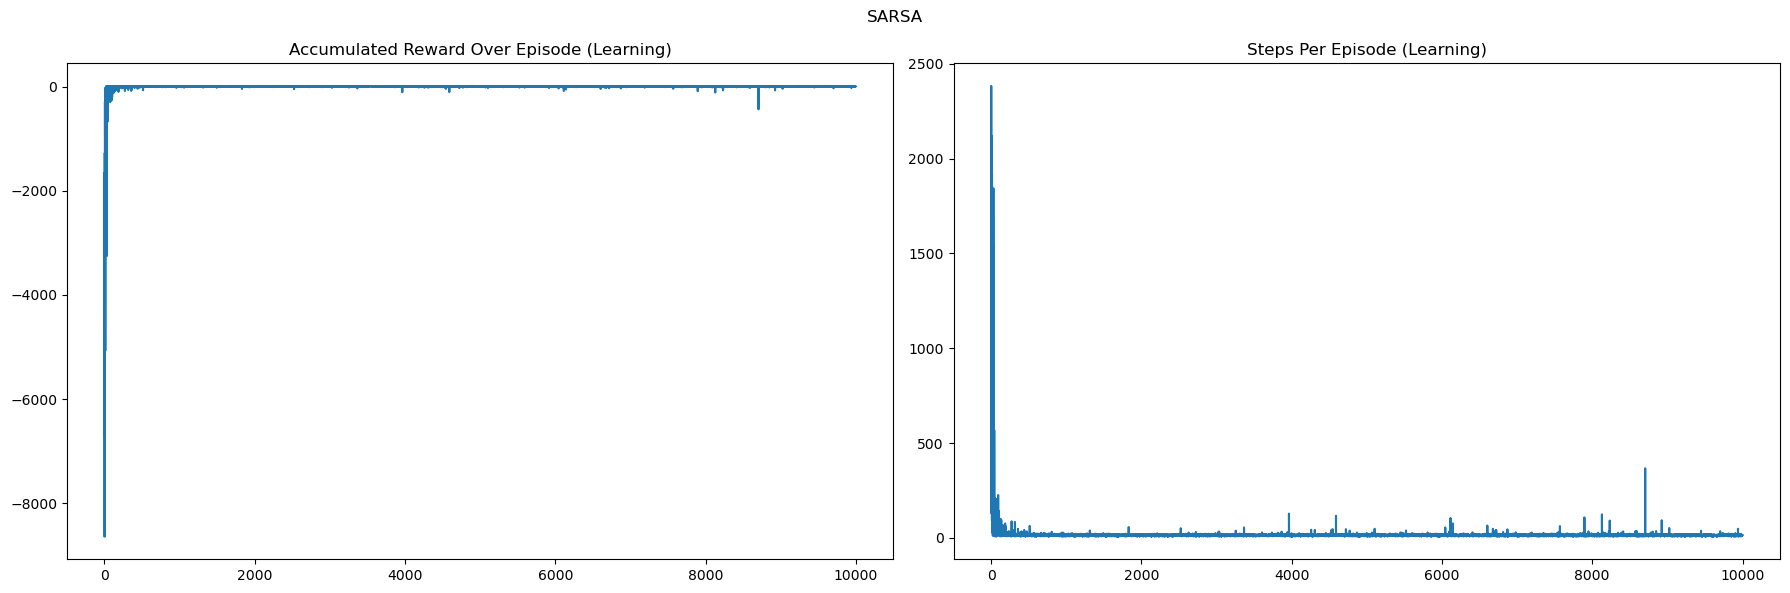

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=100)
axes = axes.flatten()

# Accumulated rewards for each episode
axes[0].plot(rewards_ss) 
axes[0].set_title("Accumulated Reward Over Episode (Learning)")

# Number of steps taken for each episode
axes[1].plot(steps_ss) 
axes[1].set_title("Steps Per Episode (Learning)")

fig.suptitle("SARSA")

plt.tight_layout()
plt.show()

#### Visualisation of trained agents from a random position

In [159]:
# Load q-table from file
q_ss = np.array(load_from_file(qtable_file_ss))

# Test the trained sarsa agent
state = env.reset()[0]
avg_rewards_ss1, avg_steps_ss1, rewards_ss1, steps_ss1 = test_agent(env, q_ss, 1, seed)

Episode: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 1
State: 234, Action: 1, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 2
State: 254, Action: 2, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 3
State: 274, Action: 2, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 4
State: 374, Action: 0, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 5
State: 474, Action: 0, Reward: -1, Total Accumulated Reward: -5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: 6
State: 478, Action: 4, Reward: -1, Total Accumulated

### Testing

In [160]:
# Load q-table from file
q_ss = np.array(load_from_file(qtable_file_ss))

# Test the trained sarsa agent
state = env.reset()[0]
avg_rewards_ss2, avg_steps_ss2, rewards_ss2, steps_ss2 = test_agent(env, q_ss, n_testing_episodes, seed)

Episode: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 1
State: 149, Action: 0, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 2
State: 249, Action: 0, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 3
State: 229, Action: 3, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 4
State: 209, Action: 3, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 5
State: 309, Action: 0, Reward: -1, Total Accumulated Reward: -5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 6
State: 409, Action: 0, Reward: -1, Total Accumulated 

+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 11
State: 197, Action: 2, Reward: -1, Total Accumulated Reward: -11
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 12
State: 97, Action: 1, Reward: -1, Total Accumulated Reward: -12
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step: 13
State: 85, Action: 5, Reward: 20, Total Accumulated Reward: 8

Episode: 137
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 1
State: 367, Action: 3, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 2
State: 267, Action: 1, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 3
State: 287, Action: 2, Reward: -1, Total Accumu

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 3
State: 248, Action: 0, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 4
State: 228, Action: 3, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 5
State: 208, Action: 3, Reward: -1, Total Accumulated Reward: -5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 6
State: 308, Action: 0, Reward: -1, Total Accumulated Reward: -6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 7
State: 408, Action: 0, Reward: -1, Total Accumulated Reward: -7
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: 8
State: 416, Action: 4, Reward: -1, Total Accumulated Reward: -8

+---------+
|R:_| : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 15
State: 36, Action: 1, Reward: -1, Total Accumulated Reward: -15
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 16
State: 16, Action: 3, Reward: -1, Total Accumulated Reward: -16
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step: 17
State: 0, Action: 5, Reward: 20, Total Accumulated Reward: 4

Episode: 282
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 1
State: 62, Action: 3, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 2
State: 162, Action: 0, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 3
State: 142, Action: 3, Reward: -1, Total Accumulat

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 6
State: 218, Action: 0, Reward: -1, Total Accumulated Reward: -6
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)

Step: 7
State: 318, Action: 0, Reward: -1, Total Accumulated Reward: -7
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 8
State: 418, Action: 0, Reward: -1, Total Accumulated Reward: -8
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step: 9
State: 410, Action: 5, Reward: 20, Total Accumulated Reward: 12

Episode: 299
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 1
State: 266, Action: 1, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 2
State: 286, Action: 2, Reward: -1, Total Accumu

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: 6
State: 17, Action: 4, Reward: -1, Total Accumulated Reward: -6
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 7
State: 117, Action: 0, Reward: -1, Total Accumulated Reward: -7
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 8
State: 217, Action: 0, Reward: -1, Total Accumulated Reward: -8
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 9
State: 237, Action: 2, Reward: -1, Total Accumulated Reward: -9
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Step: 10
State: 257, Action: 2, Reward: -1, Total Accumulated Reward: -10
+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 11
State: 157, Action: 1, Reward: -1, Total Accumulated Reward: 

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 10
State: 238, Action: 3, Reward: -1, Total Accumulated Reward: -10
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 11
State: 218, Action: 3, Reward: -1, Total Accumulated Reward: -11
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)

Step: 12
State: 318, Action: 0, Reward: -1, Total Accumulated Reward: -12
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 13
State: 418, Action: 0, Reward: -1, Total Accumulated Reward: -13
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step: 14
State: 410, Action: 5, Reward: 20, Total Accumulated Reward: 7

Episode: 490
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step: 1
State: 362, Action: 1, Reward: -1, Total

In [161]:
print("SARSA test model:")
print(f"Average accumulated reward: {avg_rewards_ss2}")
print(f"Average steps taken per episode: {avg_steps_ss2}")

SARSA test model:
Average accumulated reward: 7.2
Average steps taken per episode: 13.8


## Summary

### Q-learning (Off-policy)

- The algorithm updates Q-table based on the assumption that the agent follows the optimal policy, which maximises the the accumulated rewards, regardless of the agent's behaviour (actions taken by the agent). 
- It is suitable when exploration is necessary to find the optimal policy, as it encourages the agent to discover paths that lead to a higher long-term reward, by choosing actions that maximise the Q-value obtained from the next state. 
- However, this could lead to a potential bias as it uses evaluates actions based on the estimation of maximum Q-value of the next state. 

### SARSA (On-policy)

- The algorithm updates Q-table based on the actions taken under the policy it is currently following. 
- The algorithm is less prone to overestimation caused by potential noise (in real life). 
- However, it could potentially cause slower convergence as it takes into account of exploratory actions when updating Q-table, unlike Q-learning that gives faster convergence towards optimal policy.

Based on this experimentation, both algorithms give satisfied results and performance in terms of the average accumulated rewards and average number of steps over testing episodes. However, it is worth noticing that the learning plots for Q-learning are smoother than SARSA, which implies a more stable and consistent learning and fast convergence. On the other hand, it can be observed that there are some fluctuations during the SARSA learning process, which is reasonable as it is more sensitive towards exploration of actions. 